# Telecom Churn Project 

## Hybrid Model Evaluation

In this notebook I explore the development of a hybrid model.  The dataset has one feature that divides the population into two distinct groups.  The vast majority of customers who churn are on month-to-month contracts.  This made me wonder if we could use different models on each of these groups.

I split the whole population into those on month-to-month contracts and those on other contracts.  I then did a cross validation model shearch on each of those groups.  The best models were put together into a new predictor that utilized each model depending on the contract length of the input sample.  The results are at the graphed in an ROC-AUC graph at the end of the notebook.

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pickle

sys.path.append('../src')
from my_eval_tools import calc_roc_data
from my_eval_tools import calc_hybrid_roc_data 
from my_eval_tools import hybrid_predict, hybrid_predict_proba
from my_eval_tools import calc_pr_sweep
from my_eval_tools import predict_sweep

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


----

Read the training data file.  This file was created by running the notebooks:

* Telecom to SQL
* Telecom clean and eda

In [3]:
# Read the csv file save by the clean/eda notebook
train_df = pd.read_csv('../data/churn_train_clean.csv').drop('Unnamed: 0', axis=1)


Build the two distinct groups from this dataset.


In [4]:
# Define which columns we're going to use in our modeling.
train_columns1 = ['Month-to-month', 'SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', \
       'Fiber optic', 'Female']

train_columns2 = train_columns1.copy()
train_columns2.append('Churn')

train_columns = train_columns1

X = train_df[train_columns]
y = train_df['Churn']

month_df = train_df[train_df['Month-to-month'] == 1]
not_month_df = train_df[train_df['Month-to-month'] == 0]

X_month = month_df[train_columns].drop('Month-to-month', axis=1)
y_month= month_df['Churn']

X_not_month = not_month_df[train_columns].drop('Month-to-month', axis=1)
y_not_month = not_month_df['Churn']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
# Split the original dataset into train and validation groups
#  set stratify to true so both classes are represented it the splits
X_nm_train, X_nm_test, y_nm_train, y_nm_test = train_test_split(X_not_month, y_not_month, test_size=0.2)


X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_month, y_month, test_size=0.2)

In [7]:
# Make a balance set for model training
sm = SMOTE(random_state=42)
X_train_month_smt, y_train_month_smt = sm.fit_resample(X_m_train, y_m_train)
X_train_not_month_smt, y_train_not_month_smt = sm.fit_resample(X_nm_train, y_nm_train)
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

### Best model for Logistic Regression

In this notebook we're going to explore using a hybrid model.  For customers with month to month contracts we will use a logistic regression model.  For customers with longer contracts we will use a random forest model.

In [8]:
log_best_month = LogisticRegression(C=20, penalty='l1', solver='liblinear', random_state=45)
log_best_month.fit(X_train_month_smt,y_train_month_smt)
log_y_hat_month = log_best_month.predict(X_m_test)
print(accuracy_score(y_m_test, log_y_hat_month))

0.6649395509499136


score = 0.21
{'RFC__criterion': 'gini', 'RFC__max_depth': 4, 'RFC__max_features': 5, 'RFC__n_estimators': 50, 'RFC__random_state': 42, 'smt__random_state': 10}

score = 0.69
{'RFC__criterion': 'entropy', 'RFC__max_depth': 4, 'RFC__max_features': 15, 'RFC__n_estimators': 1000, 'RFC__random_state': 42, 'smt__random_state': 10}

In [9]:
rf_best_not_month = RandomForestClassifier(criterion='entropy', max_depth=4, max_features=15, \
        n_estimators=1000, random_state=42)
rf_best_not_month.fit(X_train_not_month_smt, y_train_not_month_smt)
rf_y_hat_not_month = rf_best_not_month.predict(X_nm_test)
print(accuracy_score(y_nm_test, rf_y_hat_not_month))

0.7322175732217573


In [10]:
roc_data_hybrid = calc_hybrid_roc_data(log_best_month, rf_best_not_month, X_test, y_test, 20)

In [17]:
# y_hat_hybrid = hybrid_predict(log_best_month, rf_best_not_month, X_test)
y_hybrid_proba = hybrid_predict_proba(log_best_month, rf_best_not_month, X_test)
y_hat_hybrid = hybrid_predict(log_best_month, rf_best_not_month, X_test)

Let's build the original logistic regression model to compare on the AUC-ROC curve

In [12]:
log_best = LogisticRegression(C=0.03, penalty='l2', solver='liblinear', random_state=45)
log_best.fit(X_train_smt,y_train_smt)
log_y_hat = log_best.predict(X_test)
log_y_hat_proba = log_best.predict_proba(X_test)
print(accuracy_score(y_test, log_y_hat))

0.7492904446546831


In [13]:
roc_data_log = calc_roc_data(log_best, X_test, y_test, 20)

In [14]:
x_plt_hybrid = [roc_data_hybrid[i][1] for i in range(len(roc_data_hybrid))]
y_plt_hybrid = [roc_data_hybrid[i][2] for i in range(len(roc_data_hybrid))]

x_plt_log = [roc_data_log[i][1] for i in range(len(roc_data_log))]
y_plt_log = [roc_data_log[i][2] for i in range(len(roc_data_log))]

In [15]:
roc_auc_score(y_test, y_hybrid_proba[:,1])

0.7755125804397213

In [18]:
f1_score(y_test, y_hat_hybrid)

0.5375722543352602

In [19]:
recall_score(y_test, y_hat_hybrid)

0.6992481203007519

In [69]:
# Save some of this data for importing into the other notebook
pickle.dump(roc_data_hybrid, open('roc_hybrid.pkl', 'wb'))

In [64]:
roc_auc_score(y_test, log_y_hat_proba[:,1])

0.824099716764825

Text(0.5, 1.0, 'ROC\n')

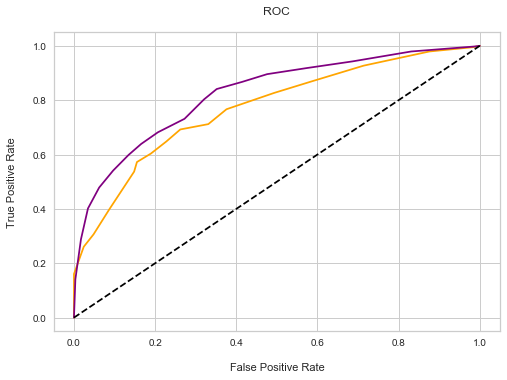

In [65]:
plt.plot(x_plt_hybrid, y_plt_hybrid, color='orange')
plt.plot(x_plt_log, y_plt_log, color='purple')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlabel('\nFalse Positive Rate')
plt.ylabel('True Positive Rate\n')
plt.title('ROC\n')